## Classification

In this section, I will fit the vectors given by BoW and TF-IDF model to various machine learning models including logistic regression (already did), naive bayes, SVM, decision tree, LightGBM and XGBoost, and ensemble learning, use grid search to fine tune parameters and use several metrics to evaluate model performance.

The accuracy and f-1 score of the baseline model (TF-IDF + logistic regression) is 0.788 and 0.786.

In order to improve model performance, I tried to do more feature engineering before training the model.

First, I constructed a customized stopword list consisting of the drug names, conditions, and other word including day, week, month, take, etc. The logic behind this is that I noticed that a lot of reviews contain drug names and conditions, but the context does does not contain any significant positive or negative feelings. This is also the case for days, weeks and months, which usually appear in sentences like "I have taken the drug for 10 days, ...". Such words might not show strong sentiment and thus do not contribute to the performance of the model.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_excel('drugs.xlsx')
print("The Shape of the Dataset :", data.shape)

The Shape of the Dataset : (20423, 9)


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
data.groupby(['condition']).count()['review'][80:90]

condition
Trintellix (vortioxetine) for Major Depressive Disorder    397
Urinary Incontinence                                         2
Viibryd (vilazodone)                                        25
Viibryd (vilazodone) for Anxiety                             3
Viibryd (vilazodone) for Depression                        562
Viibryd (vilazodone) for Major Depressive Disorder         205
Viibryd (vilazodone) for Obsessive Compulsive Disorder       1
Vulvodynia                                                   1
Wellbutrin (bupropion)                                      16
Wellbutrin (bupropion) for ADHD                              4
Name: review, dtype: int64

In [5]:
'''
'pain', 'flash', 
                  'headache', 'obesity', 'obsessive', 'disorder', 'panic', 'Dysphoric',
                  'Peripheral', 'Neuropathy', 'Sedation', 'sedation', 
                  '''

"\n'pain', 'flash', \n                  'headache', 'obesity', 'obsessive', 'disorder', 'panic', 'Dysphoric',\n                  'Peripheral', 'Neuropathy', 'Sedation', 'sedation', \n                  "

In [6]:
drug_name = ['lexapro', 'zoloft', 'prozac', 'paxil', 'celexa', 'cymbalta', 'pristiq',
             'effexor', 'bupropion', 'mirtazapine', 'trazodone', 'vilazodone',
             'vortioxetine', 'trintellix', 'viibryd', 'wellbutrin', 'bupropion', 
             'wellbutrin', 'mg', 'xl', 'sr', 'budeprion', 'sedyrel', 'aplenzin',
             'buproban', 'forfivo', 'oleptro', 'remeron', 'soltab', 
             'vortioxetine', 'viibryd', 'zyban']
condition_name = ['depression', 'anxiety']
other = ['day', 'week', 'month', 'year', 'take']

customized_stopwords = drug_name+other

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
from nltk.stem.snowball import SnowballStemmer
import spacy

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

stemmed_stopwords = []
'''
for w in customized_stopwords:
    stemmed_stopwords.append(SnowballStemmer('english').stem(lemmatizer.lemmatize(w, get_wordnet_pos(w))))
'''

for w in customized_stopwords:
    stemmed_stopwords.append(SnowballStemmer('english').stem(w))

In [9]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [10]:
stemmed_stopwords

['lexapro',
 'zoloft',
 'prozac',
 'paxil',
 'celexa',
 'cymbalta',
 'pristiq',
 'effexor',
 'bupropion',
 'mirtazapin',
 'trazodon',
 'vilazodon',
 'vortioxetin',
 'trintellix',
 'viibryd',
 'wellbutrin',
 'bupropion',
 'wellbutrin',
 'mg',
 'xl',
 'sr',
 'budeprion',
 'sedyrel',
 'aplenzin',
 'buproban',
 'forfivo',
 'oleptro',
 'remeron',
 'soltab',
 'vortioxetin',
 'viibryd',
 'zyban',
 'day',
 'week',
 'month',
 'year',
 'take']

In [11]:
import string 
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import spacy
from tqdm import tqdm

# delete all the records where Condition or rating is Missing
data = data.dropna()

# First remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str
data['review'] = data['review'].apply(punctuation_removal)

## remove special symbol
def rm_sym(df):
    df['review'] = df['review'].str.replace("&#039;",'\'')
    df['review'].head()
    return df
data = rm_sym(data)

def normalize_whitespace(text):
    """
    This function normalizes whitespaces, removing duplicates.
    """
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

#data['review']=data['review'].apply(lambda x: normalize whitespace(x))

def tokenize(text):
    split=re.split("\W+",text)
    split=split[1:-1]
    return split
data['review_list']=data['review'].apply(lambda x: tokenize(x.lower()))
#data['review_list'].head()

def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
data['review']=data['review_list'].apply(lambda x: drop_numbers(x))
data['review_list']=data['review'].apply(lambda x: tokenize(x))

def lemmatize(word_list):
    lemmatized = []
    for w in word_list:
        lemmatized.append(lemmatizer.lemmatize(w, get_wordnet_pos(w)))
    return lemmatized

data['review_list']=data['review_list'].apply(lambda x: lemmatize(x))

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

data['review_list'] = data['review_list'].apply(lambda x: remove_stopwords(x))

from nltk.stem.snowball import SnowballStemmer

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = SnowballStemmer('english')
data['review_list'] = data['review_list'].apply(lambda x: stem_tokens(x, stemmer=stemmer))


In [12]:
data['review_list']

0        [previous, celexa, wellbutrin, effexor, celexa...
2        [extrem, help, chang, life, experi, anxieti, d...
3        [take, lexapro, month, side, effect, experienc...
4        [begin, take, drug, year, ago, thought, seriou...
5        [suffer, anxieti, life, stop, drive, go, place...
                               ...                        
20317    [wellbutrin, day, amaz, wonder, felt, first, d...
20318    [month, titrat, dose, slowli, mightv, start, i...
20319    [take, medic, approxim, year, discontinu, use,...
20320    [start, wellbutrin, take, zoloft, sever, year,...
20321    [havent, medic, long, week, alreadi, tell, sig...
Name: review_list, Length: 10683, dtype: object

In [13]:
def combine(list_text):
    list_text_new = []
    for i in list_text:
        list_text_new.append(i)
    return ' '.join(list_text_new)
data['review']=data['review_list'].apply(lambda x: combine(x))

In [14]:
data['review']

0        previous celexa wellbutrin effexor celexa take...
2        extrem help chang life experi anxieti depress ...
3        take lexapro month side effect experienc tremo...
4        begin take drug year ago thought serious ill n...
5        suffer anxieti life stop drive go place alon w...
                               ...                        
20317    wellbutrin day amaz wonder felt first day take...
20318    month titrat dose slowli mightv start improv d...
20319    take medic approxim year discontinu use time d...
20320    start wellbutrin take zoloft sever year zoloft...
20321    havent medic long week alreadi tell signific d...
Name: review, Length: 10683, dtype: object

In [15]:
def remove_customized_stopwords(text):
    text=[word for word in text if word not in stemmed_stopwords]
    return text

data['review_list_new'] = data['review_list'].apply(lambda x: remove_customized_stopwords(x))

In [16]:
data['review_list_new']
data['review_new']=data['review_list_new'].apply(lambda x: combine(x))

In [17]:
data['review_new']

0        previous motiv aw ive best luck combin hydroxy...
2        extrem help chang life experi anxieti depress ...
3        side effect experienc tremor vagin numb excess...
4        begin drug ago thought serious ill numer medic...
5        suffer anxieti life stop drive go place alon w...
                               ...                        
20317    amaz wonder felt first anoth medicin never hel...
20318    titrat dose slowli mightv start improv depress...
20319    medic approxim discontinu use time depress res...
20320    start sever effect anymor though work perfect ...
20321    havent medic long alreadi tell signific differ...
Name: review_new, Length: 10683, dtype: object

In [18]:
# transform the ratings to three categories: positive, neutral and negative
def transform_rating(df):
    df['sentiment'] = ''
    df.loc[df['rating'] >= 7,'sentiment'] = 'positive'
    df.loc[df['rating'] <= 4,'sentiment'] = 'negative'
    df.loc[(df['rating'] > 4) & (df['rating'] < 7),'sentiment'] = 'neutral'
    return df
data = transform_rating(data)

# split the dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25)

In [19]:
## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [21]:
## Generate table of words with their counts
## TfidfVectorizer transform train and test
con_vec_tf = TfidfVectorizer(max_features = 10000, ngram_range = (1, 3))
X_train_tf = con_vec_tf.fit_transform(train['review'])
y_train = train['sentiment']
X_test_tf = con_vec_tf.transform(test['review'])
y_test = test['sentiment']

print(X_train_tf.shape)
print(X_test_tf.shape)

(8012, 10000)
(2671, 10000)


In [86]:
con_vec_tf = TfidfVectorizer(max_features = 20000, ngram_range = (1, 3))
X_train_tf_new = con_vec_tf.fit_transform(train['review'])
y_train = train['sentiment']
X_test_tf_new = con_vec_tf.transform(test['review'])
y_test = test['sentiment']

### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

clf_tf = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_tf.fit(X_train_tf, y_train)
y_predicted_tf = clf_tf.predict(X_test_tf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 103 epochs took 2 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


In [43]:
accuracy_tf, precision_tf, recall_tf, f1_tf = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tf, precision_tf, 
                                                                       recall_tf, f1_tf))

accuracy = 0.784, precision = 0.784, recall = 0.784, f1 = 0.784


In [87]:
from sklearn.linear_model import LogisticRegression

clf_tf_new = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_tf_new.fit(X_train_tf_new, y_train)
y_predicted_tf_new = clf_tf_new.predict(X_test_tf_new)
accuracy_tf, precision_tf, recall_tf, f1_tf = get_metrics(y_test, y_predicted_tf_new)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tf, precision_tf, 
                                                                       recall_tf, f1_tf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 82 epochs took 3 seconds
accuracy = 0.796, precision = 0.788, recall = 0.796, f1 = 0.791


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


Accuracy: 0.78
Auc: 0.83
Detail:
              precision    recall  f1-score   support

    negative       0.77      0.75      0.76       856
     neutral       0.33      0.26      0.29       234
    positive       0.84      0.88      0.86      1581

    accuracy                           0.78      2671
   macro avg       0.65      0.63      0.64      2671
weighted avg       0.77      0.78      0.78      2671



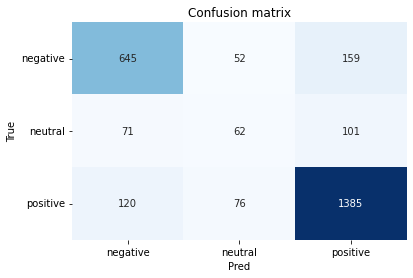

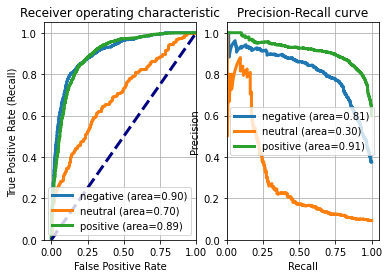

In [ ]:
predicted = y_predicted_tf
predicted_prob = clf_tf.predict_proba(X_test_tf)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

Accuracy: 0.8
Auc: 0.85
Detail:
              precision    recall  f1-score   support

    negative       0.75      0.77      0.76       814
     neutral       0.41      0.25      0.31       218
    positive       0.85      0.88      0.87      1639

    accuracy                           0.80      2671
   macro avg       0.67      0.63      0.65      2671
weighted avg       0.78      0.80      0.79      2671



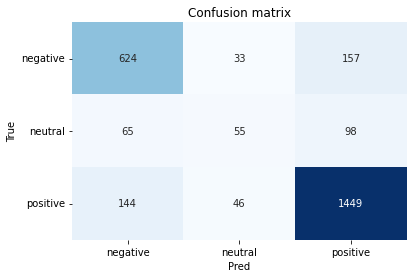

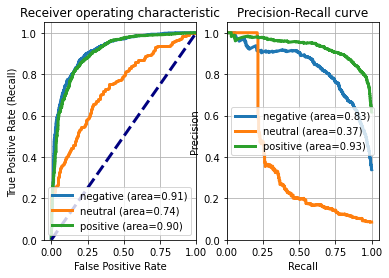

In [60]:
predicted = y_predicted_tf_new
predicted_prob = clf_tf_new.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
coef_lr = pd.DataFrame(clf_tf_new.coef_,columns=con_vec_tf.get_feature_names(),index=clf_tf_new.classes_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Rating as "positive": top 20 of Positive coeffients

Rating as "positive": top 20 of Negative coeffients
Rating as "negative": top 20 of Positive coeffients

Rating as "negative": top 20 of Negative coeffients


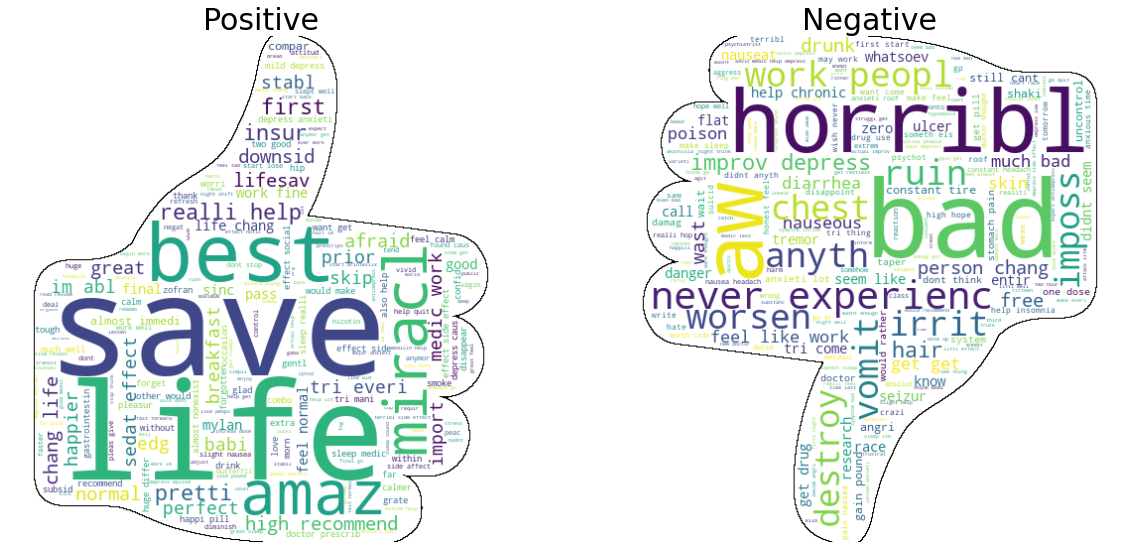

In [ ]:
from PIL import Image
import PIL.ImageOps 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

thumb_up= np.array(Image.open("70420.png"))
thumb_up = 255 - thumb_up
thumb_down = np.fliplr(thumb_up)[::-1]

def top_20_pos_neg_wordcloud(category,mask):

    print('Rating as "' + category +'": top 20 of Positive coeffients')
    #print(coef_lr.loc[category].nlargest(20))

    print('\nRating as "' + category +'": top 20 of Negative coeffients')
    #print(coef_lr.loc[category].nsmallest(20))

    wordcloud = WordCloud(contour_width=1,background_color='white',mask=mask)
    wordcloud.generate_from_frequencies(frequencies=coef_lr.loc[category])

    #plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
plt.figure(figsize=(20,10)) 
plt.subplot(1, 2, 1)
top_20_pos_neg_wordcloud('positive',thumb_up)
plt.title("Positive",fontsize=30)

plt.subplot(1, 2, 2)
top_20_pos_neg_wordcloud('negative',thumb_down)
plt.title("Negative",fontsize=30)

plt.savefig('thumb_up_down_wordcloud.png', bbox_inches = 'tight', pad_inches = 0)

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 600, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
rfc = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rfc_cv_score = cross_val_score(rfc,X_train_tf,y_train,scoring='accuracy',cv=3,n_jobs=-1)
rfc_cv_score

KeyboardInterrupt: ignored

In [82]:
#rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1)
#rfc_cv_score = cross_val_score(rfc,X_train_tf_new,y_train,scoring='accuracy',cv=3,n_jobs=-1)
#rfc_cv_score
rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1,oob_score=True, min_samples_leaf=1,
                             min_samples_split=2)
rfc.fit(X_train_tf_new,y_train)
y_test_rfc_predict = rfc.predict(X_test_tf_new)
rfc_conf_mat = confusion_matrix(y_test,y_test_rfc_predict)
accuracy_score(y_test,y_test_rfc_predict)

0.7686259827779858

In [83]:
#rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1)
#rfc_cv_score = cross_val_score(rfc,X_train_tf_new,y_train,scoring='accuracy',cv=3,n_jobs=-1)
#rfc_cv_score
rfc = RandomForestClassifier(n_estimators=600,n_jobs=-1,oob_score=True, min_samples_leaf=1,
                             min_samples_split=2)
rfc.fit(X_train_tf_new,y_train)
y_test_rfc_predict = rfc.predict(X_test_tf_new)
rfc_conf_mat = confusion_matrix(y_test,y_test_rfc_predict)
accuracy_score(y_test,y_test_rfc_predict)

0.7727442905278922

In [68]:
accuracy_rf, precision_rf, recall_rf, f1_rf = get_metrics(y_test, y_test_rfc_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_rf, precision_rf, 
                                                                       recall_rf, f1_rf))

accuracy = 0.767, precision = 0.798, recall = 0.767, f1 = 0.738


Accuracy: 0.78
Auc: 0.85
Detail:
              precision    recall  f1-score   support

    negative       0.86      0.54      0.66       814
     neutral       1.00      0.20      0.34       218
    positive       0.75      0.97      0.85      1639

    accuracy                           0.78      2671
   macro avg       0.87      0.57      0.62      2671
weighted avg       0.80      0.78      0.75      2671



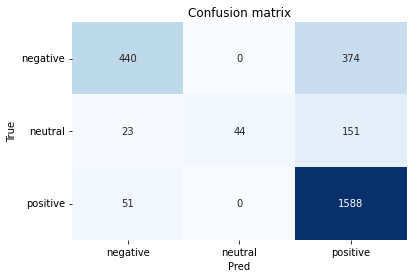

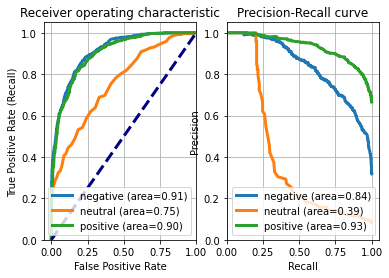

In [29]:
predicted = y_test_rfc_predict
predicted_prob = rfc.predict_proba(X_test_tf)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


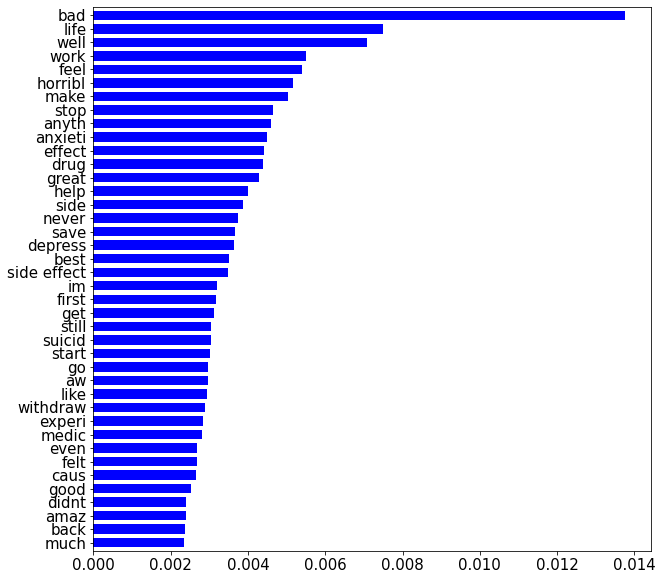

In [ ]:
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,con_vec_tf.get_feature_names())
plt.figure(figsize=(10,10))
rfc_feature_importances[0].nlargest(40)[::-1].plot(kind='barh',color='blue',fontsize=15,width=0.7)
plt.savefig("rfc_feat_import.png")

### SVM

In [88]:
from sklearn import svm

svm = svm.SVC(kernel='poly', degree=2, probability=True)

svm.fit(X_train_tf_new, y_train)
y_predicted_svm = svm.predict(X_test_tf_new)

In [ ]:
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_predicted_svm)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_svm, precision_svm, 
                                                                       recall_svm, f1_svm))

accuracy = 0.790, precision = 0.814, recall = 0.790, f1 = 0.763


In [89]:
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_predicted_svm)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_svm, precision_svm, 
                                                                       recall_svm, f1_svm))

accuracy = 0.785, precision = 0.816, recall = 0.785, f1 = 0.758


In [90]:
from sklearn import svm

svm = svm.SVC(kernel='rbf', probability=True)

svm.fit(X_train_tf_new, y_train)
y_predicted_svm = svm.predict(X_test_tf_new)

In [91]:
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_predicted_svm)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_svm, precision_svm, 
                                                                       recall_svm, f1_svm))

accuracy = 0.810, precision = 0.824, recall = 0.810, f1 = 0.785


Accuracy: 0.81
Auc: 0.87
Detail:
              precision    recall  f1-score   support

    negative       0.82      0.70      0.75       814
     neutral       1.00      0.14      0.25       218
    positive       0.80      0.95      0.87      1639

    accuracy                           0.81      2671
   macro avg       0.87      0.60      0.63      2671
weighted avg       0.82      0.81      0.79      2671



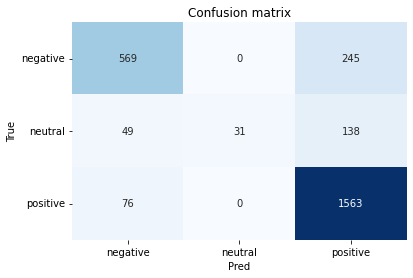

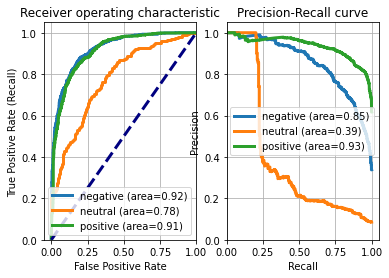

In [92]:
predicted = y_predicted_svm
predicted_prob = svm.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Multinomial Naive Bayes

In [93]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tf_new, y_train)
y_predicted_nb = nb.predict(X_test_tf_new)

In [94]:
accuracy_nb, precision_nb, recall_nb, f1_nb = get_metrics(y_test, y_predicted_nb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_nb, precision_nb, 
                                                                       recall_nb, f1_nb))

accuracy = 0.700, precision = 0.692, recall = 0.700, f1 = 0.633


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.73
Auc: 0.82
Detail:
              precision    recall  f1-score   support

    negative       0.85      0.49      0.62       856
     neutral       0.00      0.00      0.00       234
    positive       0.71      0.98      0.82      1581

    accuracy                           0.73      2671
   macro avg       0.52      0.49      0.48      2671
weighted avg       0.69      0.73      0.68      2671



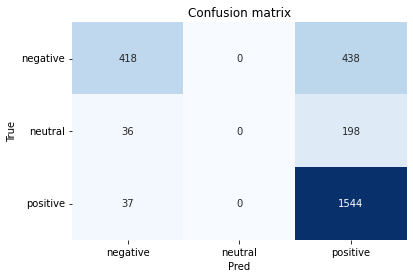

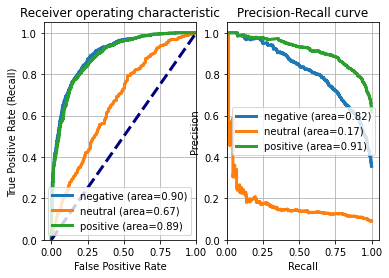

In [ ]:
predicted = y_predicted_nb
predicted_prob = nb.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier 
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
abc.fit(X_train_tf_new, y_train)
y_predicted_abc = abc.predict(X_test_tf_new)

In [ ]:
accuracy_abc, precision_abc, recall_abc, f1_abc = get_metrics(y_test, y_predicted_abc)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_abc, precision_abc, 
                                                                       recall_abc, f1_abc))

accuracy = 0.698, precision = 0.668, recall = 0.698, f1 = 0.667


Accuracy: 0.7
Auc: 0.74
Detail:
              precision    recall  f1-score   support

    negative       0.68      0.54      0.60       856
     neutral       0.33      0.06      0.10       234
    positive       0.71      0.88      0.79      1581

    accuracy                           0.70      2671
   macro avg       0.58      0.49      0.49      2671
weighted avg       0.67      0.70      0.67      2671



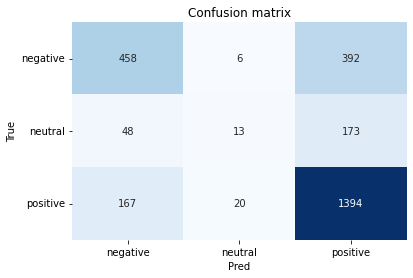

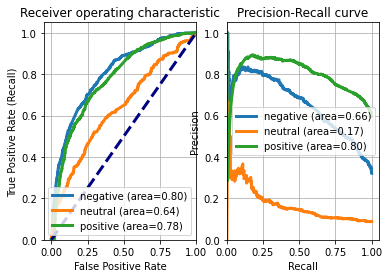

In [ ]:
predicted = y_predicted_abc
predicted_prob = abc.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### XGBoost

In [95]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
xgb_model = xgb.XGBClassifier(random_state=6, use_label_encoder=False, n_jobs=-1)

In [ ]:
lr = [0.05,0.1]
max_depth=np.arange(5,10)
n_estimators=[500, 1000, 1500]
#gamma=np.arange(0,0.1,0.01)

param_grid = dict(learning_rate=lr, max_depth=max_depth, n_estimators=n_estimators)

grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5)
grid_result = grid_search.fit(X_train_tf_new, y_train)

result_lgr = pd.DataFrame(grid_result.cv_results_)
result_lgr.sort_values(by='mean_test_score', ascending=False)[:4]

In [96]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 500)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)

In [33]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

accuracy = 0.803, precision = 0.799, recall = 0.803, f1 = 0.786


In [97]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

accuracy = 0.801, precision = 0.794, recall = 0.801, f1 = 0.784


In [100]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

accuracy = 0.802, precision = 0.790, recall = 0.802, f1 = 0.787


In [102]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

accuracy = 0.802, precision = 0.790, recall = 0.802, f1 = 0.787


In [101]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 9, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

accuracy = 0.795, precision = 0.784, recall = 0.795, f1 = 0.780


In [36]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf, y_train)
y_predicted_xgb = xgb.predict(X_test_tf)

In [37]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

accuracy = 0.803, precision = 0.798, recall = 0.803, f1 = 0.788


In [52]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)

In [53]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

accuracy = 0.798, precision = 0.792, recall = 0.798, f1 = 0.783


Accuracy: 0.8
Auc: 0.85
Detail:
              precision    recall  f1-score   support

    negative       0.77      0.73      0.75       814
     neutral       0.75      0.23      0.35       218
    positive       0.82      0.91      0.86      1639

    accuracy                           0.80      2671
   macro avg       0.78      0.63      0.66      2671
weighted avg       0.80      0.80      0.79      2671



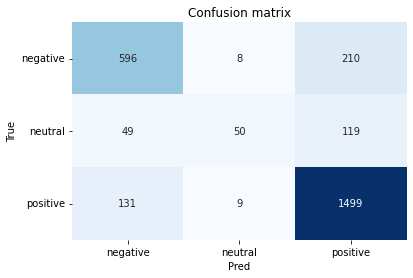

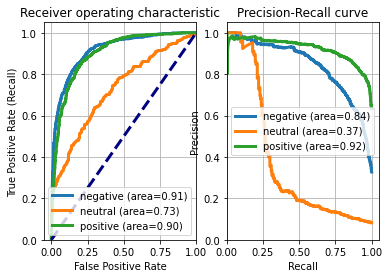

In [39]:
predicted = y_predicted_xgb
predicted_prob = xgb.predict_proba(X_test_tf)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### LightGBM

In [ ]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
lgb.fit(X_train_tf_new, y_train)
y_predicted_lgb = lgb.predict(X_test_tf_new)

In [ ]:
accuracy_lgb, precision_lgb, recall_lgb, f1_lgb = get_metrics(y_test, y_predicted_lgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_lgb, precision_lgb, 
                                                                       recall_lgb, f1_lgb))

accuracy = 0.698, precision = 0.668, recall = 0.698, f1 = 0.667


Accuracy: 0.77
Auc: 0.84
Detail:
              precision    recall  f1-score   support

    negative       0.77      0.68      0.72       856
     neutral       0.73      0.13      0.22       234
    positive       0.78      0.92      0.84      1581

    accuracy                           0.77      2671
   macro avg       0.76      0.58      0.59      2671
weighted avg       0.77      0.77      0.75      2671



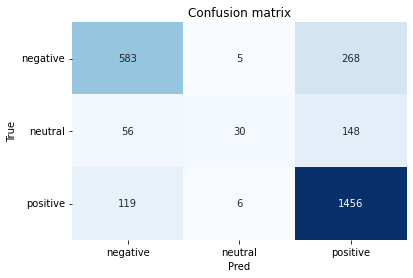

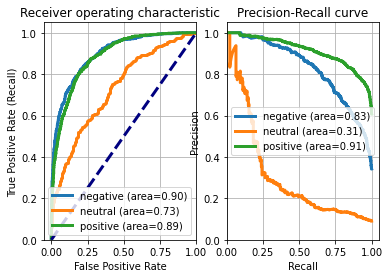

In [ ]:
predicted = y_predicted_lgb
predicted_prob = lgb.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## Ensemble Learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=0) # probability calculation
logClf = LogisticRegression(random_state=0)
#nbclf = GaussianNB(random_state=0)

# constructing the ensemble classifier by mentioning the individual classifiers.
clf2 = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf), ('log', logClf)], voting='soft') 

# train the ensemble classifier
clf2.fit(X_train_tf_new, y_train)

In [103]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('SVC', svm), ('LogReg', clf_tf), ('XGB', xgb)], voting='hard')
voting_clf.fit(X_train_tf_new, y_train)
preds = voting_clf.predict(X_test_tf_new)
acc = accuracy_score(y_test, preds)
acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


0.8109322351179333

In [105]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('SVC', svm), ('LogReg', clf_tf), ('XGB', xgb)], voting='soft')
voting_clf.fit(X_train_tf_new, y_train)
preds = voting_clf.predict(X_test_tf_new)
acc = accuracy_score(y_test, preds)
acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


0.8068139273680269

Accuracy: 0.81
Auc: 0.87
Detail:
              precision    recall  f1-score   support

    negative       0.77      0.76      0.76       814
     neutral       0.53      0.23      0.32       218
    positive       0.84      0.91      0.87      1639

    accuracy                           0.81      2671
   macro avg       0.71      0.63      0.65      2671
weighted avg       0.79      0.81      0.79      2671



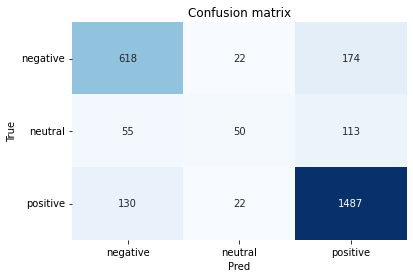

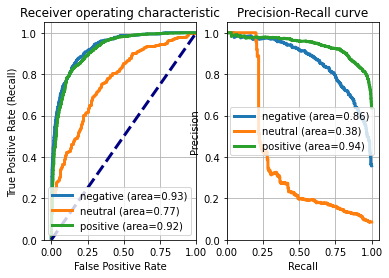

In [106]:
predicted = preds
predicted_prob = voting_clf.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [108]:
from sklearn.ensemble import BaggingClassifier

logreg_bagging_model = BaggingClassifier(base_estimator=clf_tf, n_estimators=50, random_state=12)
logreg_bagging_model.fit(X_train_tf_new, y_train)
preds_log = logreg_bagging_model.predict(X_test_tf_new)
acc_log = accuracy_score(y_test, preds_log)
acc_log

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

0.8101834518906776

Accuracy: 0.81
Auc: 0.85
Detail:
              precision    recall  f1-score   support

    negative       0.76      0.78      0.77       814
     neutral       0.54      0.24      0.33       218
    positive       0.85      0.90      0.87      1639

    accuracy                           0.81      2671
   macro avg       0.72      0.64      0.66      2671
weighted avg       0.80      0.81      0.80      2671



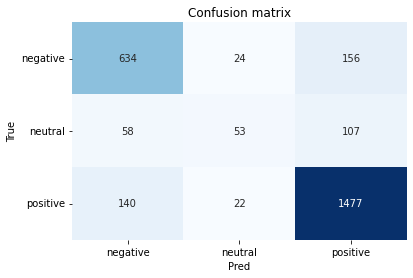

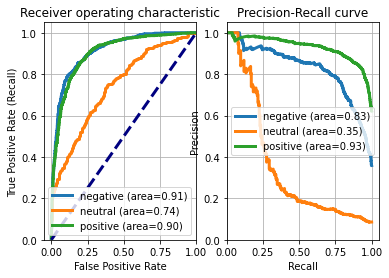

In [109]:
predicted = preds_log
predicted_prob = logreg_bagging_model.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()